In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [38]:
from datasets import load_dataset
dataset = load_dataset("financial_phrasebank", "sentences_50agree")

df = dataset['train'].to_pandas()

Found cached dataset financial_phrasebank (C:/Users/fabian/.cache/huggingface/datasets/financial_phrasebank/sentences_50agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

<Axes: >

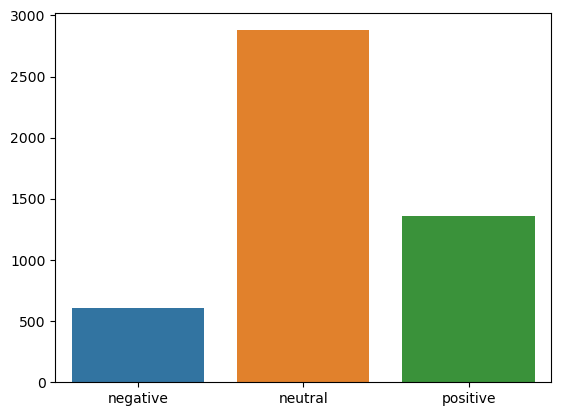

In [39]:
count = df['label'].value_counts()
bar_data = pd.DataFrame({'negative': [count[0]], 'neutral': [count[1]]
        , 'positive': [count[2]]})
sns.barplot(data=bar_data)

# Preprocessing

In [40]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

In [41]:
# Lemmatize
lemma = WordNetLemmatizer()
stopwords = stopwords.words('english')

def clean_text(text: str) -> list:
    corpus = str(text).lower()
    corpus = re.sub('[^a-zA-Z]+',' ', corpus).strip()
    tokens = word_tokenize(corpus)
    words = [i for i in tokens if i not in stopwords]
    lemmatize = [lemma.lemmatize(w) for w in words]

    return lemmatize

preprocess_text = [clean_text(i) for i in df['sentence']]
df['preprocess_text'] = preprocess_text

# Method 1 Positive and Negative Word Count with Normalization

In [42]:
# Importing list of positive and negative words
with open('positive-words.txt', 'r') as file1:
    pos_words = file1.read()

with open('negative-words.txt', 'r') as file2:
    neg_words = file2.read()

pos_words = [i for i in pos_words.split('\n')]
neg_words = [i for i in neg_words.split('\n')]

count_pos = df['preprocess_text'].map(lambda x: len([i for i in x if i in pos_words]))
count_neg = df['preprocess_text'].map(lambda x: len([i for i in x if i in neg_words]))

df['count_pos'] = count_pos
df['count_neg'] = count_neg

df['total_len'] = df['preprocess_text'].map(lambda x: len(x))

df['sentiment_score'] = round((df['count_pos'] - df['count_neg']) /df['total_len'], 2)


In [62]:
'''
Let's test the accuracy of the sentiment score
We set an arbitrary classification rule of the following:

sentiment_score < -threshold     ---> Negative
-threshold<=sentiment_score<=threshold ---> Neutral
sentiment_score > threshold     ---> Positive

with the threshold being a value we can set.
'''

def score_classification(score, threshold):
    if score < -threshold:
        res = 0
    elif score <= threshold:
        res = 1
    else:
        res = 2
    
    return res

thresholds = [0.01, 0.02, 0.05, 0.10, 0.2, 0.5, 0.75, 1] # list of threshold values we can test

for threshold in thresholds:
    df['sentiment_score {}'.format(threshold)] = df['sentiment_score'].map(lambda x: score_classification(x, threshold))
    result = df.apply(lambda x: 1 if x['sentiment_score {}'.format(threshold)] == x['label'] else 0, axis=1).sum()
    df.drop(['sentiment_score {}'.format(threshold)], axis=1)
    accuracy = result / len(df) * 100
    print("The overall accuracy with a threshold of {} is {:.2f}%".format(threshold, accuracy))


The overall accuracy with a threshold of 0.01 is 54.91%
The overall accuracy with a threshold of 0.02 is 54.91%
The overall accuracy with a threshold of 0.05 is 55.28%
The overall accuracy with a threshold of 0.1 is 57.94%
The overall accuracy with a threshold of 0.2 is 59.33%
The overall accuracy with a threshold of 0.5 is 59.29%
The overall accuracy with a threshold of 0.75 is 59.33%
The overall accuracy with a threshold of 1 is 59.39%


## Method 2 VADER SentimentIntensityAnalyser

In [54]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [59]:
sent = SentimentIntensityAnalyzer()

polarity = [round(sent.polarity_scores(t)['compound'], 2) for t in df['sentence']]
df['sentiment_score (VADER)'] = polarity

In [63]:
# Using the same rule of classification as before
for threshold in thresholds:
    df['sentiment_score (VADER) {}'.format(threshold)] = df['sentiment_score (VADER)'].map(lambda x: score_classification(x, threshold))
    result = df.apply(lambda x: 1 if x['sentiment_score (VADER) {}'.format(threshold)] == x['label'] else 0, axis=1).sum()
    df.drop(['sentiment_score {}'.format(threshold)], axis=1)
    accuracy = result / len(df) * 100
    print("The overall accuracy (VADER) with a threshold of {} is {:.2f}%".format(threshold, accuracy))


The overall accuracy (VADER) with a threshold of 0.01 is 30.69%
The overall accuracy (VADER) with a threshold of 0.02 is 30.69%
The overall accuracy (VADER) with a threshold of 0.05 is 30.69%
The overall accuracy (VADER) with a threshold of 0.1 is 30.69%
The overall accuracy (VADER) with a threshold of 0.2 is 30.69%
The overall accuracy (VADER) with a threshold of 0.5 is 30.69%
The overall accuracy (VADER) with a threshold of 0.75 is 30.69%
The overall accuracy (VADER) with a threshold of 1 is 54.52%


# Train Test Split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    df['sentence'], df['label'], test_size=0.2, random_state=42)

In [46]:
'''
Look at the medium article to handle imbalanced class
'''

'\nLook at the medium article to handle imbalanced class\n'